# Excess Mortality Analysis

In this notebook we will attempt to calculate the excess deaths in Germany during the COVID-19 epidemic. We base our analysis on the dataset of weekly deaths since 2000 in Germany obtained from eurostat. Based on the trend and periodogram of the time series we generate numerical features that capture the temporal structure of the deaths in Germany enabling us to train and compare various machine learning algorithms that can then be used to predict the mortality of the time period starting from 2020 in the absence of corona. 
This prediction can then be compared to the actual mortality yielding an estimation for the number of excess deaths during the COVID-19 pandemic.

## 1. Data and relevant Libraries
We conduct our analysis using Python. The main libraries used are`scipy` which we use to analyze the seasonality of the weekly deaths, `statsmodels` for generating the temporal features used in our machine learning pipeline which itself is based `scikit-learn` and `matplotlib` for visualizing our results. Besides that we also use `pandas` and `numpy` to perform some auxillary tasks.

The data comes from [EuroStat](https://ec.europa.eu/eurostat/data/database) as an excel table containing the weekly Deaths in Germany from 2000 until now (March 2022). The preprocessing of this data is done in the `Analytics` module by the function `eurostats_loader` which returns the data as a pandas DataFrame 

In [2]:
from Analytics import eurostats_loader
import pandas as pd
import numpy as np
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy.signal import periodogram, detrend
from sklearn.linear_model  import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Adjust color cycle of plots (first line HS-blue second line burgundy red, turqouise)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#0645ad", "#800020", "#1EB9E7", ]) 
mpl.rcParams['figure.dpi'] = 100

## 2. Preparing the Data.
We discard all observations before 2008 since including them would distort the trend estimation for our model due to the fact that the demography or Germany is undergoing significant changes, since 2008 the mortality has been increasing linerarly specifically. 

The preprocessed data is then split into a training-, validation- and test-set. We use a validation set for comparing model performace. The test set contains the periods from 2020 onward, hence the time period since COVID-19 started to spread.

In [3]:
Weekly_Deaths = eurostats_loader()
Weekly_Deaths = Weekly_Deaths[Weekly_Deaths.index.year >= 2008]

Weekly_Deaths_train = Weekly_Deaths[Weekly_Deaths.index.year < 2019]
Weekly_Deaths_val = Weekly_Deaths[Weekly_Deaths.index.year == 2019]
Weekly_Deaths_test = Weekly_Deaths[Weekly_Deaths.index.year > 2019]

Text(0.5, 1.0, 'Weekly Deaths in Germany 2000-2022')

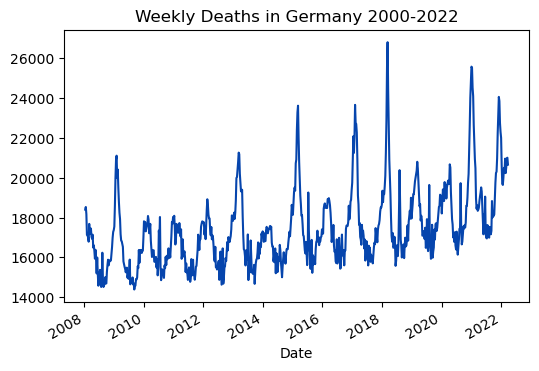

In [4]:
Weekly_Deaths.Value.plot().set_title("Weekly Deaths in Germany 2000-2022")

## 3. Analyzing seasonality
A visual inspectation of `Weekly_Deaths` gives evidence for the existence of a seasonal pattern in the mortality. In general seasonal patterns can be modeled via sine and cosine periodic functions. The mathematical theory of Fourier Analysis provides tools for finding the periodic functions that best model the seasonality of our data. The `periodogram` function from scipy is one such tool. By mapping the time series from its representation in the time domain (x-axis) to a domain (x-axis) of frequencies where peaks indicate that a sine or cosine function with the corresponding frequency models a part or the entire seasonality of the time series.

<figure>
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/7/72/Fourier_transform_time_and_frequency_domains_%28small%29.gif"/>
<figcaption style="color:white;font-size:10px;" face="Droid Sans">Visual Intuition behind the Periodogram. </figcaption>   
</center>
<figure>

In addition to the time series to be mapped, we can set the frequency domain to which it will be mapped via the argument `fs`. By setting fs to be equal to the number of weeks per year scale the frequency domain such that one year is equal to a frequency of one. For the periodogram to be accurate the time series needs to be stationary which can be achieved by detrending it beforehand. The type of trend can be set via the `detrend` argument, to us a linear trend seems to be an appropriate choice. Setting the argument `scaling` to `"spectrum"` makes sure that the following equality is fulfilled:

$$ \operatorname{Var}(X)=\int_{-\infty}^{\infty} S_{x x}(f) d f \hspace{1cm}(3.1)$$

where $X$ are the values of the time series and $f$ the frequencies returned by `periodogram`. The function $S_{x x}(f)$ is the so-called power spectrum which due to the above equation can be interpreted as the amount of variance of the times series explained by each frequency $f$. Note that due to the fact that $f$ returned by the periodogram is discrete the integration turns into summation.

In [5]:
fs = pd.Timedelta("1Y") / pd.Timedelta("1W")
print(f"fs: {fs}\n")
f, Sxx = periodogram(Weekly_Deaths_train.Value, detrend="linear", fs=fs, scaling="spectrum")
# The Power Spectrum Sxx indicates the share of each frequency of the variance of the Time Series.
print("Is equation (3.1) fulfilled?\n")
print(f"Sxx: {np.sum(Sxx)}")
# Weekly Deaths need to be detrended because the periodogram is fitted on the detrended series.
print(f"Var: {np.var(detrend(Weekly_Deaths_train.Value))}\n")
# Peak of periodogram
print(f"Peak frequency: {f[np.argmax(Sxx)]}")

fs: 52.1775

Is equation (3.1) fulfilled?

Sxx: 2637245.088299226
Var: 2637245.088299227

Peak frequency: 1.0034134615384613


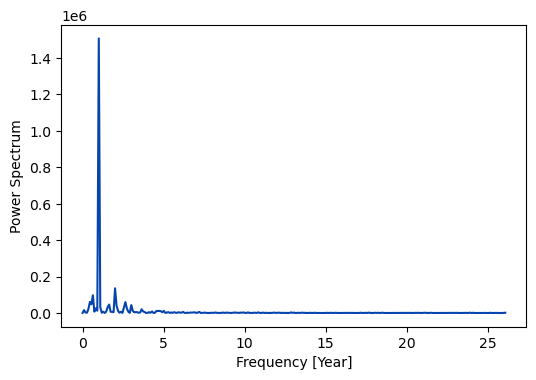

In [6]:
plt.plot(f, Sxx)
plt.xlabel('Frequency [Year]')
plt.ylabel('Power Spectrum')
plt.show()

## 4. Generating temporal Features
In this section we create features for our machine learning models. Although it would be feasible to take the entire time axis of the time series `Weekly Deaths` as feature vector this would force us to use a highly complex model because it would need to deduce seasonality and trend together from time dates alone. Due to the fact that the time series appears to have a trend and periodogram analysis in section 3 gave overwhelming evidence for yearly seasonality we decided to directly handcraft these features since this enhances the explainability of our models which is crucial in a medical context.

The function `DeterministicProcess` from statsmodels is used to generate features for each component of our time series. DeterministicProcess will generate features for the three components we use to model our time series, namely the average of the series or its *level*, its trend and its seasonality. Although DeterministicProcess has to arguments `seasonal` and `fourier` we decide to create the periodic features ourselves via `CalendarFourier` since it enables us to control the frequency of the functions. After comparing model performance for different values of `order` in CaldendarFourier we decided to set it to 3. This gives the model enough flexibility to adapt to the not entirerly sinosoidal shape of the peaks of the time series.

In [8]:
fourierA = CalendarFourier(freq="A", order=3)


y_train = Weekly_Deaths_train.Value

dp = DeterministicProcess(index=y_train.index.to_period("W"),
                          constant=True,               # dummy feature for bias (y-intercept)
                          order=1,                     # trend (order 1 means linear)
                          additional_terms=[fourierA],) # annual seasonality (fourier)


X_train = dp.in_sample()

val_index = Weekly_Deaths_val.index
X_val = dp.out_of_sample(len(val_index), val_index)

For a more closer look at the features generated by `dp.in_sample()` run the cells below.

In [9]:
X_train.head()

,const,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)"
Date,,,,,,,,
2008-01-07/2008-01-13,1.0,1.0,0.102821,0.994700,0.204552,0.978856,0.304115,0.952635
2008-01-14/2008-01-20,1.0,2.0,0.221325,0.975200,0.431673,0.902030,0.620609,0.784120
2008-01-21/2008-01-27,1.0,3.0,0.336637,0.941634,0.633978,0.773351,0.857315,0.514793
2008-01-28/2008-02-03,1.0,4.0,0.447094,0.894487,0.799839,0.600214,0.983798,0.179281
2008-02-04/2008-02-10,1.0,5.0,0.551102,0.834438,0.919720,0.392574,0.983798,-0.179281


Text(0.5, 1.0, 'Sine Features')

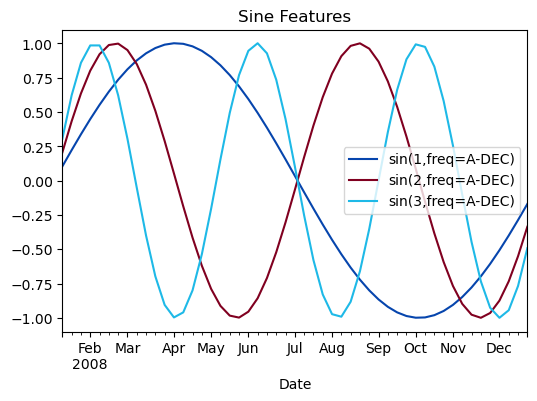

In [10]:
X_train[["sin(1,freq=A-DEC)", "sin(2,freq=A-DEC)", "sin(3,freq=A-DEC)"]].loc[X_train.index<"2009"].plot().set_title("Sine Features")

## 5. Fit Models
We fit and compare the performance of two models on the training data `D = (X_train, y_train)` containing the time series components as features and the Weekly Deaths until 2020 as predicted variable. In essence the models try to combine the components generated by `DeterministicProcess` in such a way that their sum looks like `y_train`. While Linear Regression is a well known technique the second algorithm we used might not be familiar to everyone. We also had to decide which loss function to use to measure the *goodness of fit* of our models and make asses the trade-off between performance and interpretability.

### 5.1 Gradient Boosting
The idea behind Gradient Boosting is the stepwise combination of so called weak learners into an ensemble of models whose aggregate predictions are comparable to those of a more complex model. In our case the weak learners are *decision stumps* meaning decision trees with only one node. Gradient boosting works by calculating the gradient of the loss function after adding a new decision stump to the ensemble and then fitting a new decision stump to it, this procedure is repeated `n_estimator` of times. It can be thought of as a form of regularized gradient descent which prevents the model from overfitting by simply matching the data exactly since each decision stump is trained on the entire training data `D`. 

### 5.2 Evaluating the Models

We chose the *mean squared error* (mse) as loss function to measure the goodness of fit of our models. One advantage of the mse is that it penalizes large deviations from the true value while being lenient on small deviations. In the context of excess mortality prediction this makes sense since it isn't to important to get the number of deaths exactly right but rather to approximate them sufficiently well. For better interpretability of the performance we judge the model performance by the absolute error instead of the mse. A model that has a lower absolute error also has a lower mse. In the plot below it can be seen that `GradientBoostingRegressor` has roughly 10% lower absolute error than `LinearRegression`. It would be of interest to find a way to measure the statistical significance of such a performance improvement. It would also be interesting to try to come up with an evaluation strategy that uses more than one validation set, unfortunately the temporal structure of or data prevents us from using cross-validation for more accurate performance assesment.

## 5.3. Which Model to choose?
In the end we have to decide which model to use not only based on its performance but also based on its interpretability. Although `LinearRegression` is not alot worse than `GradientBoostingRegressor` and has a far superior interpretability, we have yet to find a scientific article that used `GradientBoostingRegressor` for excess mortality prediction. For the sake of novelty we therefore chose to calculate the excess mortality for 2020-2022 via our Gradient Boosting model.

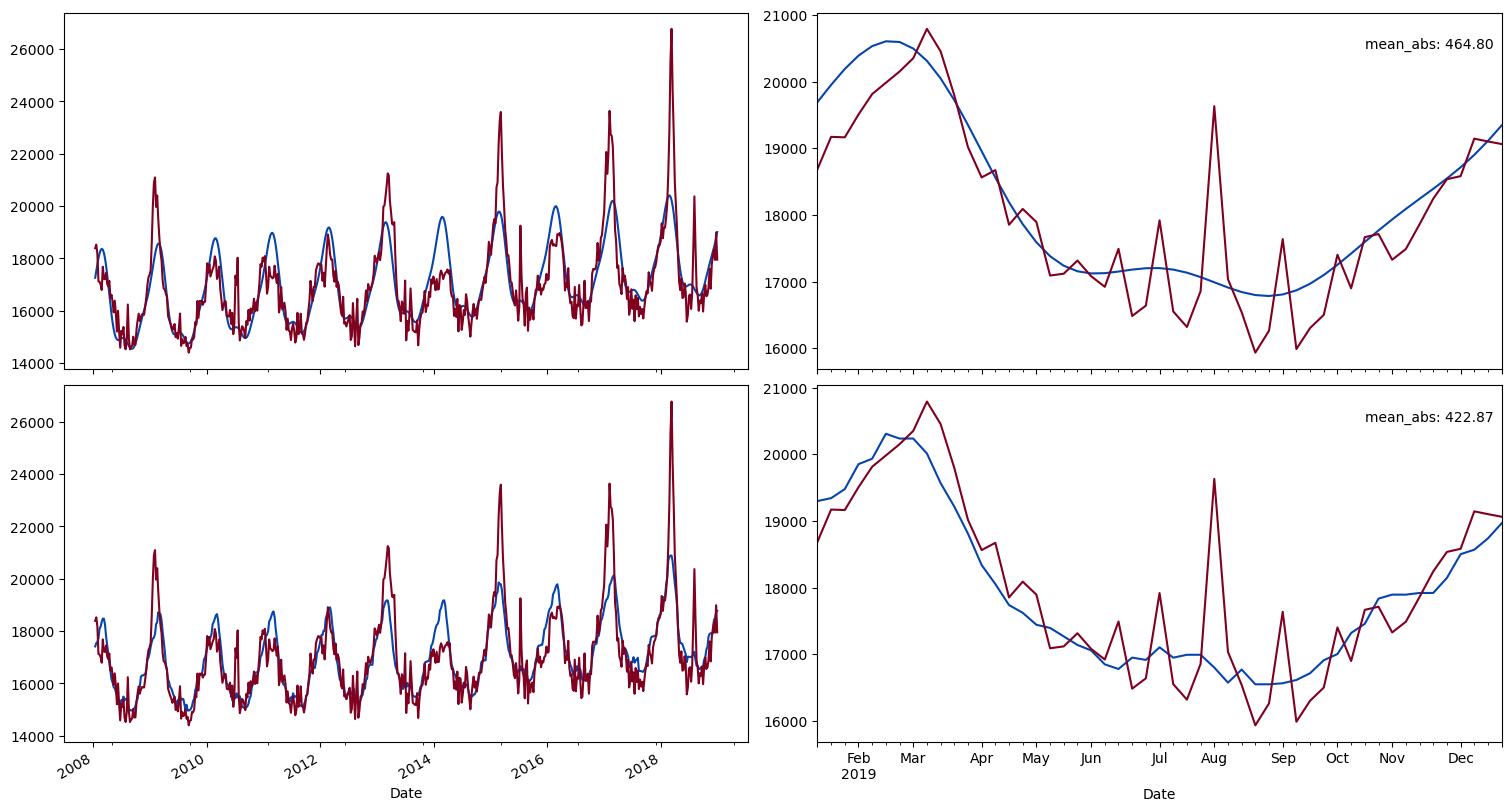

In [13]:
Models = [LinearRegression(fit_intercept=False),
          GradientBoostingRegressor(max_depth=1, n_estimators=150)]

num_models = len(Models)
fig, axes = plt.subplots(num_models,2,layout="constrained",sharex="col",figsize = (15,8))

for i,model in enumerate(Models):
    
    model.fit(X_train,y_train)
    y_pred = pd.Series(model.predict(X_train).reshape(-1), index=y_train.index)
    y_val = pd.Series(model.predict(X_val).reshape(-1), index=val_index)
    
    abs_err = np.mean(abs(y_val-Weekly_Deaths_val.Value))
    
    ax_train = axes[i,0]
    #ax_train.set_title(type(model).__name__)
    y_pred.plot(ax=ax_train)
    Weekly_Deaths_train.Value.plot(ax=ax_train)
    
    ax_val = axes[i,1]
    ax_val.axes.annotate(f"mean_abs: {abs_err:.2f}", xy=(0.8,0.9), xycoords='axes fraction', fontsize=10)
    y_val.plot(ax=ax_val)
    Weekly_Deaths_val.Value.plot(ax=ax_val)

## 6. Excess Mortality Estimation
We now use our Gradient Boosting model to estimate the number of excess deaths between the start of 2020 and March 2022 in Germany. Our model estimates roughly $131000$ excess deaths in comparisson to two "normal" years with winterly influenza waves. 

Text(0.5, 1.0, 'Estimated Excess Deaths in Germany 2020-2022')

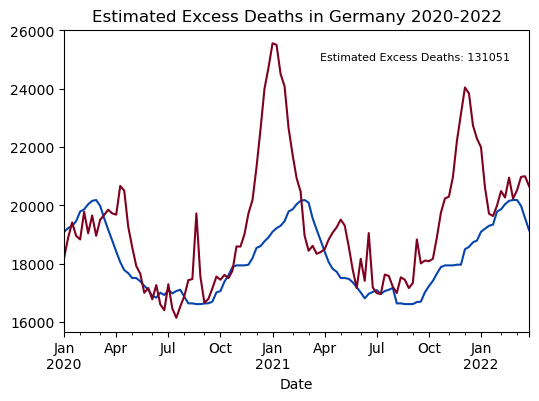

In [12]:
y_comb_train = Weekly_Deaths[Weekly_Deaths.index.year < 2020]

dp = DeterministicProcess(index=y_comb_train.index.to_period("W"),
                          constant=True,               # dummy feature for bias (y-intercept)
                          order=1,                     # trend (order 1 means linear)
                          additional_terms=[fourierA],)  # annual seasonality (fourier)


X_comb_train = dp.in_sample()

model = GradientBoostingRegressor(max_depth=1)
model.fit(X_comb_train, y_comb_train)
y_comb_pred = pd.Series(model.predict(X_comb_train).reshape(-1), index=y_comb_train.index)


test_index = Weekly_Deaths_test.index
X_test = dp.out_of_sample(len(test_index), test_index)
y_test = pd.Series(model.predict(X_test).reshape(-1), index=test_index)
excess_deaths = np.sum(Weekly_Deaths_test.Value-y_test)

fig_test, ax_test = plt.subplots()
ax_test.axes.annotate(f"Estimated Excess Deaths: {excess_deaths:.0f}", xy=(0.55,0.9), xycoords='axes fraction', fontsize=8)
y_test.plot(ax=ax_test)
Weekly_Deaths_test.Value.plot(ax=ax_test).set_title("Estimated Excess Deaths in Germany 2020-2022")

## 7. Sources
1. Hastie, T., Tibshirani, R.,, Friedman, J. (2009). The elements of statistical learning: data mining, inference and prediction. Springer.
2. Ashbacher, C. (2005). All the Mathematics You Missed (But Need to Know for Graduate School). School Science and Mathematics
3. https://www.kaggle.com/learn/time-series